<a href="https://colab.research.google.com/github/JunhOpportunity/AI_lab/blob/main/week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cuda device


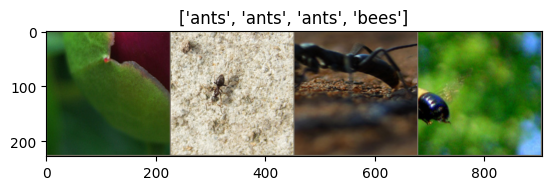

Epoch 0/24
----------
train Loss: 3.5040 Acc: 0.4303
val Loss: 1.8052 Acc: 0.6601

Epoch 1/24
----------
train Loss: 0.5641 Acc: 0.7951
val Loss: 1.6001 Acc: 0.7386

Epoch 2/24
----------
train Loss: 0.4211 Acc: 0.8320
val Loss: 0.7647 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.4548 Acc: 0.8197
val Loss: 0.7314 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.3829 Acc: 0.8238
val Loss: 0.5971 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4390 Acc: 0.8320
val Loss: 0.5888 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.3603 Acc: 0.8443
val Loss: 0.4509 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3696 Acc: 0.8238
val Loss: 0.5440 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3298 Acc: 0.8648
val Loss: 0.4752 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2964 Acc: 0.8770
val Loss: 0.4363 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2882 Acc: 0.8811
val Loss: 0.4888 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3020 Acc: 0.8811
val Loss: 0.4147 Acc: 0.9216

Ep

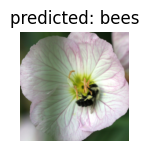

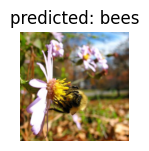

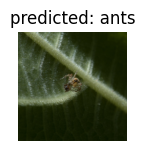

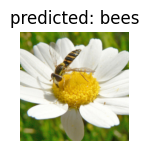

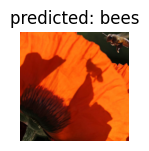

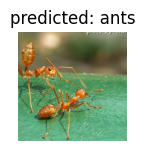

Epoch 0/24
----------
train Loss: 0.6324 Acc: 0.6639
val Loss: 0.4473 Acc: 0.7647

Epoch 1/24
----------
train Loss: 0.4346 Acc: 0.8074
val Loss: 0.2972 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.5753 Acc: 0.7582
val Loss: 0.2132 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.4349 Acc: 0.8074
val Loss: 0.1783 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5627 Acc: 0.7459
val Loss: 0.3243 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4090 Acc: 0.8484
val Loss: 0.2644 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.5826 Acc: 0.7418
val Loss: 0.2383 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3944 Acc: 0.8115
val Loss: 0.2198 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4589 Acc: 0.8074
val Loss: 0.2075 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3314 Acc: 0.8525
val Loss: 0.2155 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3160 Acc: 0.8648
val Loss: 0.2093 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3700 Acc: 0.8484
val Loss: 0.2670 Acc: 0.9216

Ep

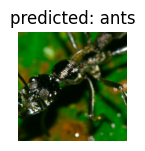

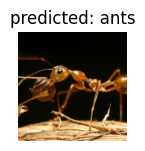

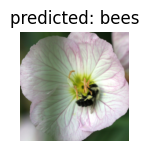

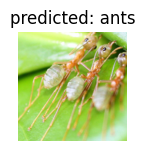

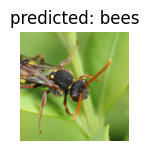

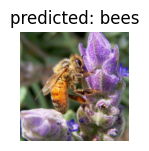

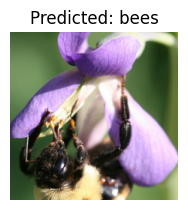

In [6]:
# License: BSD
# Author: Sasank Chilamkurthy
# efficientnet_b3
# 마지막 레이어 입력 차원 가져오기 num_ftrs = model_ft.classifier[1].in_features
import zipfile
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# 압축 파일 경로와 풀 경로 지정
zip_path = '/content/hymenoptera_data.zip'
extract_path = 'output_folder'

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# ZIP 파일 열기 및 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load DATA
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'output_folder/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# efficientnet_b3
# 마지막 레이어 입력 차원 가져오기 num_ftrs = model_ft.classifier[1].in_features

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)


visualize_model_predictions(
    model_conv,
    img_path='/content/output_folder/hymenoptera_data/val/bees/72100438_73de9f17a.jpg'
)

plt.ioff()
plt.show()


Using cuda device


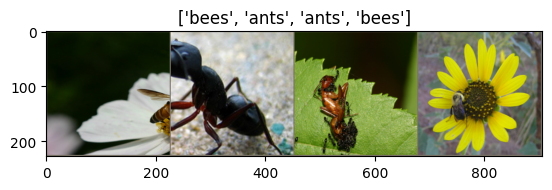

Epoch 0/24
----------
train Loss: 0.6779 Acc: 0.6721
val Loss: 0.1987 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.3704 Acc: 0.8443
val Loss: 0.4254 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.5290 Acc: 0.8074
val Loss: 0.3010 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.5653 Acc: 0.8197
val Loss: 0.5057 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.4621 Acc: 0.8156
val Loss: 0.3078 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.6048 Acc: 0.7500
val Loss: 0.5854 Acc: 0.7974

Epoch 6/24
----------
train Loss: 0.4535 Acc: 0.8033
val Loss: 0.4069 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.3825 Acc: 0.8607
val Loss: 0.2898 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.2982 Acc: 0.8689
val Loss: 0.2705 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.3271 Acc: 0.8893
val Loss: 0.2506 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2588 Acc: 0.8934
val Loss: 0.2513 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3942 Acc: 0.8484
val Loss: 0.2417 Acc: 0.9281

Ep

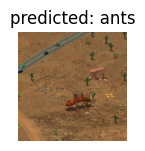

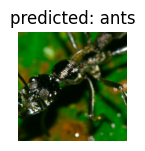

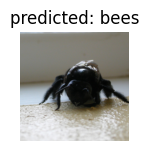

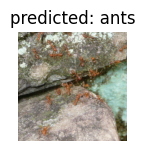

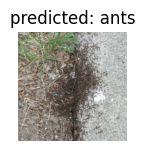

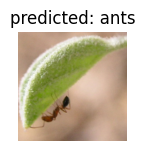

Epoch 0/24
----------
train Loss: 0.6559 Acc: 0.5902
val Loss: 0.2423 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4353 Acc: 0.8238
val Loss: 0.2562 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4941 Acc: 0.7951
val Loss: 0.2005 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5031 Acc: 0.7582
val Loss: 0.1858 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4292 Acc: 0.8156
val Loss: 0.1932 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5537 Acc: 0.7664
val Loss: 0.1726 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4285 Acc: 0.8115
val Loss: 0.2729 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3581 Acc: 0.8566
val Loss: 0.1601 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4503 Acc: 0.8361
val Loss: 0.1690 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3439 Acc: 0.8402
val Loss: 0.1700 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3264 Acc: 0.8443
val Loss: 0.2041 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3076 Acc: 0.8770
val Loss: 0.1858 Acc: 0.9412

Ep

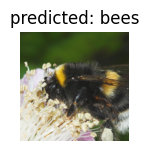

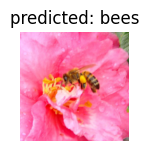

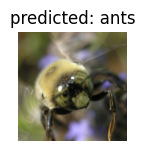

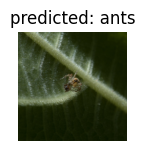

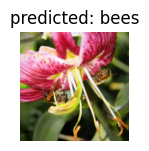

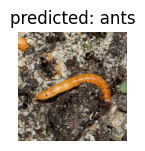

In [7]:
# License: BSD
# Author: Sasank Chilamkurthy
import zipfile
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# 압축 파일 경로와 풀 경로 지정
zip_path = '/content/hymenoptera_data.zip'
extract_path = 'output_folder'

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# ZIP 파일 열기 및 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load DATA
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'output_folder/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)

model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()